In [3]:
import numpy as np
from scipy.optimize import least_squares
from matplotlib import pyplot as plt

from sklearn.gaussian_process.kernels import RBF, Matern
import h5py

source_dataset = "../Datasets/Dataset_forumtracking.hdf5"
final_dataset = "forumtracking.hdf5"

origin = "4"

max_trajectory_length = 100
max_nr_trajectories = 100
filter_parameter = ("", 3)
goals = [el for el in range(1,9)]
!pip install shapely

%run preprocessing.py

# defines:
# filter_by_origin(path, goal, target=None)
# filter_by_length(path, length, target=None)
# filter_by_number(path, number, target=None)
# filter_trajectory(data, kind=None, windowsize=3)
# adjust_trajectory_length(trajectory, length)
# dp_algorithm(tolerance, trajectory)
# dp_cost_function(tolerance, trajectory)
# process_trajectory(trajectory, length, filter_parameter)

distributed 1.21.8 requires msgpack, which is not installed.


# Hier wird der Mean zufällig gemacht

# PREPROCESSING FEHLT HIER, final_dataset genauer anschauen

In [4]:
#img_forum = cv2.imread("../Datasets/Images/forumtracking.png")

i = 0
with h5py.File(final_dataset, "r") as f:
    count_total = f.attrs["TotalNrTrajectories"]
    X_forum = np.zeros((count_total, max_trajectory_length,2))
    y_forum = np.zeros((count_total,))
    for goal in f:
        for traj in f[goal]:
            trajectory = process_trajectory(f[goal+"/"+traj+"/Positions"][:], \
                                                  max_trajectory_length, \
                                                  filter_parameter)
            X_forum[i] = trajectory
            y_forum[i] = int(goal)
            i += 1

(763, 100, 2)


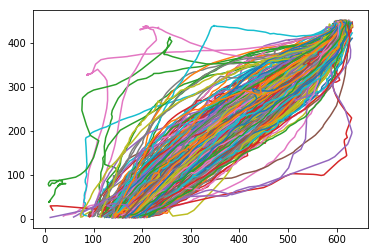

In [5]:
data = X_forum[np.where(y_forum==4)]
print(data.shape)
for traj in data:
    plt.plot(traj[:,0], traj[:,1])
plt.show()

# Mean & Variance

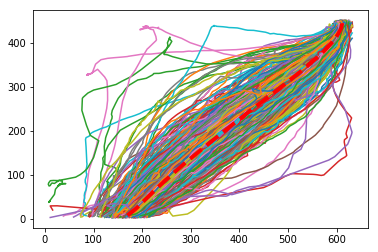

In [153]:
mx = np.mean(data[:,:,0],axis=0)
my = np.mean(data[:,:,1],axis=0)

for traj in data:
    plt.plot(traj[:,0], traj[:,1])
plt.plot(mx,my,linewidth=4,linestyle="--",c="r")
plt.show()

real_x_var = np.var(data[:,:,0],axis=0)
real_y_var = np.var(data[:,:,1],axis=0)
plt.plot(real_x_var,label="var(x)")
plt.plot(real_y_var,label="var(y)")
plt.legend()
plt.show()


In [162]:
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111)

for traj in data:
    ax.plot(traj[:,0], traj[:,1],c="b",linestyle="--",alpha=0.2)
ax.plot(mx,my)
ax.fill_between(mx+np.sqrt(real_x_var), my - np.sqrt(real_y_var), my + np.sqrt(real_y_var), alpha=1, color='r')
ax.fill_between(mx-np.sqrt(real_x_var), my - np.sqrt(real_y_var), my + np.sqrt(real_y_var), alpha=1, color='r')
plt.show()

(100, 100)


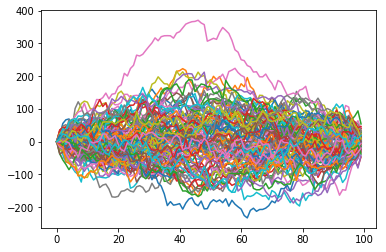

In [118]:
seed = 0
length_samples = 100
n_samples = 100
scale = 150 
#np.random.seed(seed)
import six
 
def sample_path_batch(n_samples, length_samples, scale):
    dt = (1.0 / length_samples)
    dt_sqrt = np.sqrt(dt)*scale
    B = np.empty((n_samples, length_samples), dtype=np.float32)
    B[:, 0] = 0
    for n in six.moves.range(length_samples - 1):
        t = n * dt
        xi = np.random.randn(n_samples) * dt_sqrt
        B[:, n + 1] = B[:, n] * (1 - dt / (1 - t)) + xi
    return B
 
 
B = sample_path_batch(n_samples, length_samples,scale)
print(B.shape)
plt.plot(B.T)
plt.show()

50.0


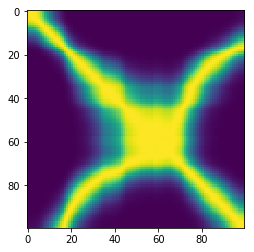

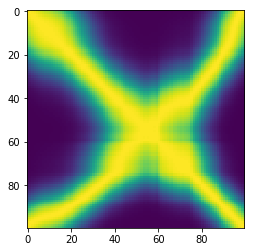

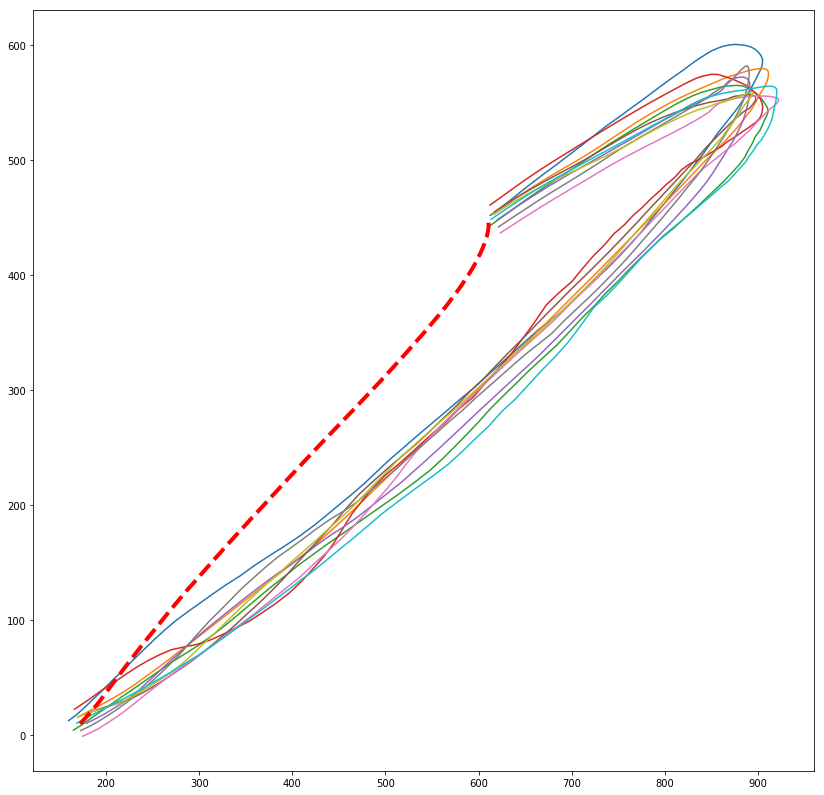

In [138]:
scale_x = 50
scale_y = 50
ls_x, ls_y = 250, 250

kx = RBF(length_scale=ls_x)(real_x_std.reshape(100,1))*scale_x
ky = RBF(length_scale=ls_y)(real_y_std.reshape(100,1))*scale_y
print(np.max(kx))
plt.imshow(kx)
plt.show()
plt.imshow(ky)
plt.show()

n_samples = 10

fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111)

for i in range(n_samples):
    mean_x = mx# + sample_path_batch(n_samples=1, length_samples=100, scale=1)[0] * np.std(data[:,:,0],axis=0)*3
    mean_y = my# + sample_path_batch(n_samples=1, length_samples=100, scale=1)[0] * np.std(data[:,:,1],axis=0)*3
    
    x_samples = np.random.multivariate_normal(mean=mean_x, cov=kx, size=1)[0,:] * (np.sin(np.linspace(0,np.pi,100))+1)
    y_samples = np.random.multivariate_normal(mean=mean_y, cov=ky, size=1)[0,:] * (np.sin(np.linspace(0,np.pi,100))+1)
    #print(y_samples.shape)
    #print(real_y_std.shape)
    ax.plot(x_samples, y_samples)

    
#for traj in data:
#    ax.plot(traj[:,0], traj[:,1],c="b",linestyle="--",alpha=0.2)
    
ax.plot(mx,my,linewidth=4,linestyle="--",c="r")

    
    
plt.show()



# Allgemeine Varianz


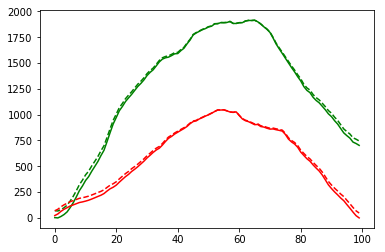

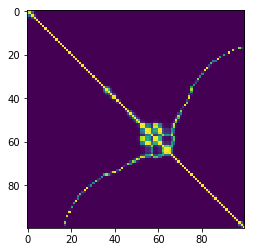

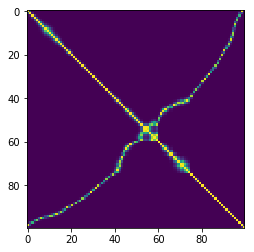

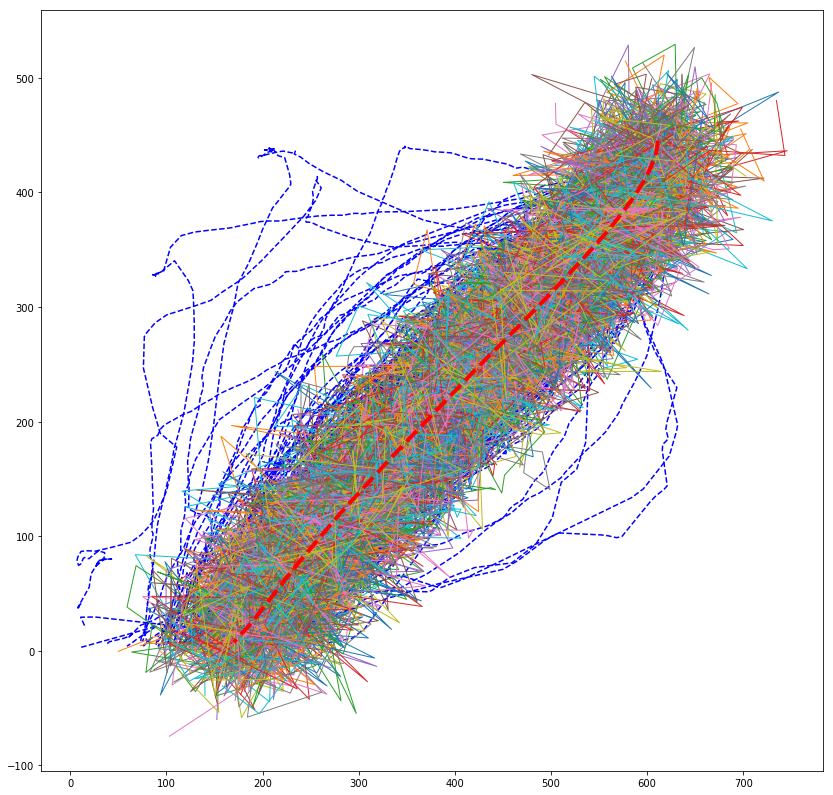

(100,)


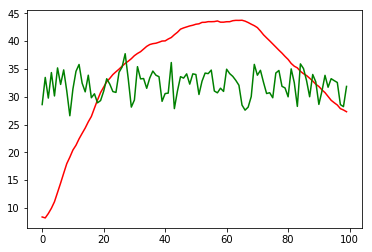

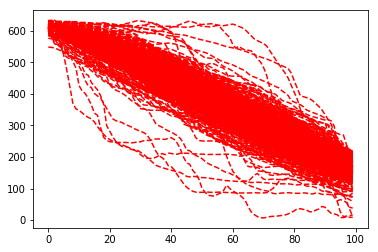

In [147]:
#x_std = np.load("x_std_mean.npy")
#y_std = np.load("y_std_mean.npy")
x_std = real_x_std
y_std = real_y_std

ls_x, ls_y = 10, 10
scale_x, scale_y = np.max(x_std), np.max(y_std)

plt.plot(x_std,c="g",linestyle="--")
x_std = (x_std-np.min(x_std))/(np.max(x_std)-np.min(x_std))*np.max(x_std)
plt.plot(x_std,c="g")
plt.plot(y_std,c="r",linestyle="--")
y_std = (y_std-np.min(y_std))/(np.max(y_std)-np.min(y_std))*np.max(y_std)
plt.plot(y_std,c="r")
plt.show()


#kx = RBF(length_scale=ls_x)(x_std.reshape(100,1))*scale_x
#ky = RBF(length_scale=ls_y)(y_std.reshape(100,1))*scale_y
kx = Matern(length_scale=ls_x)(x_std.reshape(100,1))*scale_x
ky = Matern(length_scale=ls_y)(y_std.reshape(100,1))*scale_y

plt.imshow(kx)
plt.show()
plt.imshow(ky)
plt.show()

n_samples = 100
x_samples = np.random.multivariate_normal(mean=mx, cov=kx, size=n_samples)
y_samples = np.random.multivariate_normal(mean=my, cov=ky, size=n_samples)

fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111)
for traj in data:
    plt.plot(traj[:,0], traj[:,1],c="b",linestyle="--")
for i in range(n_samples):
    ax.plot(x_samples[i], y_samples[i], linewidth=1)
ax.plot(mx,my,linewidth=4,linestyle="--",c="r")

plt.show()
print(np.std(data[:,:,0],axis=0).shape)
plt.plot(np.std(data[:,:,0],axis=0),c="r")
plt.plot(np.std(y_samples,axis=0),c="g")
plt.show()


for traj in data:
    plt.plot(traj[:,0],c="r",linestyle="--")
plt.show()
for traj in data:
    plt.plot(traj[:,1],c="b",linestyle="--")
plt.show()

# Unterschiedliche Kernels


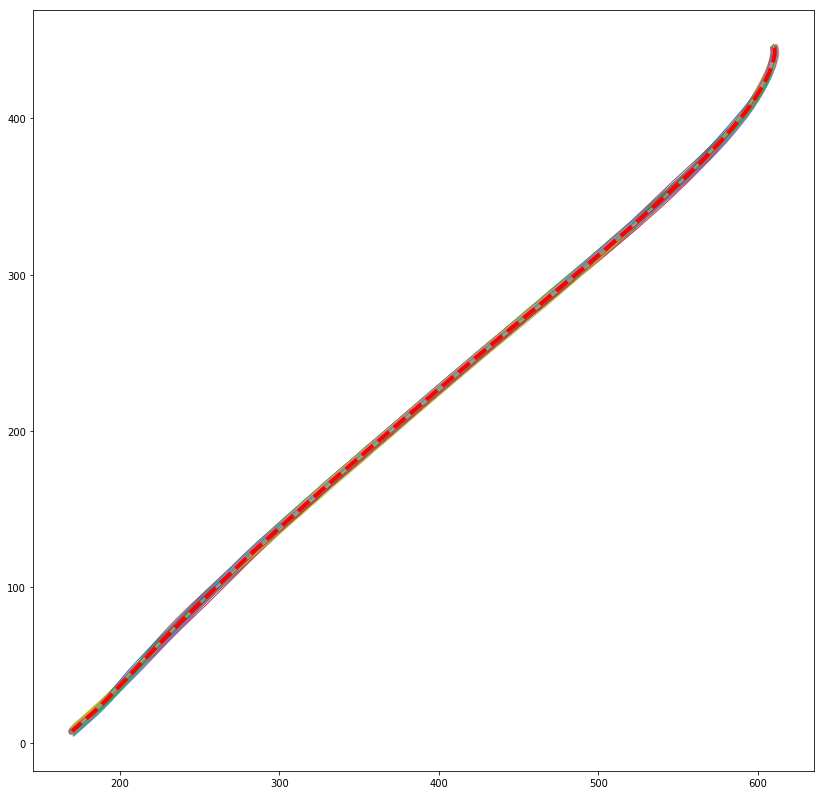

In [19]:
x_std = np.load("x_std_mean.npy")
y_std = np.load("y_std_mean.npy")

n_samples = 200
ls_x, ls_y = 5, 5
scale = 1

kx = RBF(length_scale=ls_x)(x_std.reshape(100,1))*scale
ky = RBF(length_scale=ls_y)(y_std.reshape(100,1))*scale


x_rbf_samples = np.random.multivariate_normal(mean=mx, cov=kx, size=n_samples)
y_rbf_samples = np.random.multivariate_normal(mean=my, cov=ky, size=n_samples)

fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111)


for i in range(n_samples):
    ax.plot(x_rbf_samples[i], y_rbf_samples[i], linewidth=1)
ax.plot(mx,my,linewidth=4,linestyle="--",c="r")
plt.show()

kx = Matern(length_scale=ls_x)(x_std.reshape(100,1))*scale
ky = Matern(length_scale=ls_y)(y_std.reshape(100,1))*scale


x_mat_samples = np.random.multivariate_normal(mean=mx, cov=kx, size=n_samples)
y_mat_samples = np.random.multivariate_normal(mean=my, cov=ky, size=n_samples)

fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111)

for i in range(n_samples):
    ax.plot(x_mat_samples[i], y_mat_samples[i], linewidth=1)
ax.plot(mx,my,linewidth=4,linestyle="--",c="r")
plt.show()

(100,)
(200, 100)


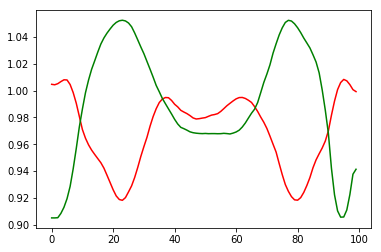

In [20]:
print(np.std(x_rbf_samples,axis=0).shape)
#plt.plot(x_std,c="g")
print(x_rbf_samples.shape)
plt.plot(np.std(x_rbf_samples,axis=0),c="r")
plt.plot(np.std(y_rbf_samples,axis=0),c="g")
plt.show()

# Find optimal Parameters

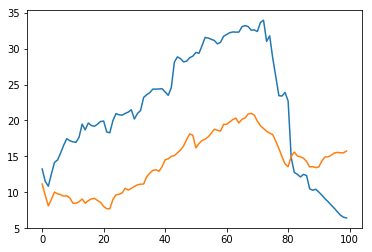

In [142]:
plt.plot(real_x_std)
plt.plot(real_y_std)
plt.show()

In [14]:
x0 = np.array([5.0, 5.0, 35, 20], dtype=float)
bounds = ([1e-9,1e-9,1e-1,1e-1], [2e2,2e2,1e2,1e2])

def to_minimize(x):
    ls_x, ls_y, scale_x, scale_y = x

    #x_std = (real_x_std-np.min(real_x_std))/(np.max(real_x_std)-np.min(real_x_std))*scale_x
    #y_std = (real_y_std-np.min(real_y_std))/(np.max(real_y_std)-np.min(real_y_std))*scale_y
    x_std = real_x_std
    y_std = real_y_std

    #kx = RBF(length_scale=ls_x)(x_std.reshape(100,1))*scale_x
    #ky = RBF(length_scale=ls_y)(y_std.reshape(100,1))*scale_y
    kx = Matern(length_scale=ls_x)(x_std.reshape(100,1))*scale_x
    ky = Matern(length_scale=ls_y)(y_std.reshape(100,1))*scale_y

    n_samples = 250
    x_samples = np.random.multivariate_normal(mean=mx, cov=kx, size=n_samples)
    y_samples = np.random.multivariate_normal(mean=my, cov=ky, size=n_samples)

    new_x_std = np.std(x_samples,axis=0)
    new_y_std = np.std(y_samples,axis=0)
    return np.max([np.linalg.norm(real_x_std-new_x_std), np.linalg.norm(real_y_std-new_y_std)])
    
test = to_minimize(np.array([2,2,10,10]))
print(test)

res = least_squares(fun=to_minimize,x0=x0)#, bounds=bounds)
print(res)

324.77757955362813
 active_mask: array([0., 0., 0., 0.])
        cost: 40198.903422451134
         fun: array([283.54507022])
        grad: array([ 1.30333638e+09,  2.51024711e+09, -2.32845588e+08,  2.98858485e+09])
         jac: array([[ 4596575.70970023,  8853079.72061866,  -821194.274407  ,
        10540069.85705039]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 15
        njev: 4
  optimality: 2988584847.7194514
      status: 3
     success: True
           x: array([28.84361475, 41.32903858, 50.69795877, 33.67530879])


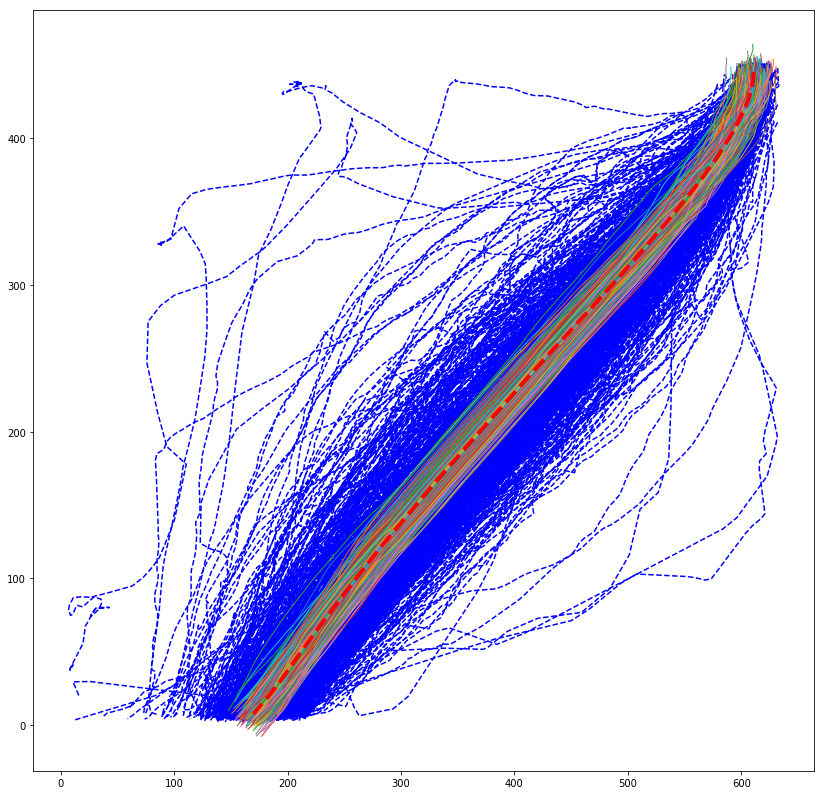

In [16]:
x_std = real_x_std
y_std = real_y_std

n_samples = 200
s_x, ls_y, scale_x, scale_y = res.x

kx = Matern(length_scale=ls_x)(x_std.reshape(100,1))*scale_x
ky = Matern(length_scale=ls_y)(y_std.reshape(100,1))*scale_y

n_samples = 250
x_samples = np.random.multivariate_normal(mean=mx, cov=kx, size=n_samples)
y_samples = np.random.multivariate_normal(mean=my, cov=ky, size=n_samples)

fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111)

for traj in data:
    ax.plot(traj[:,0],traj[:,1],c="b",linestyle="--")
for i in range(n_samples):
    ax.plot(x_samples[i], y_samples[i], linewidth=1)
ax.plot(mx,my,linewidth=4,linestyle="--",c="r")


    
plt.show()


In [143]:
def bounded_random_walk(length, lower_bound,  upper_bound, start, end, std):
    assert (lower_bound <= start and lower_bound <= end)
    assert (start <= upper_bound and end <= upper_bound)

    bounds = upper_bound - lower_bound

    rand = (std * (np.random.random(length) - 0.5)).cumsum()
    rand_trend = np.linspace(rand[0], rand[-1], length)
    rand_deltas = (rand - rand_trend)
    rand_deltas /= np.max([1, (rand_deltas.max()-rand_deltas.min())/bounds])

    trend_line = np.linspace(start, end, length)
    upper_bound_delta = upper_bound - trend_line
    lower_bound_delta = lower_bound - trend_line

    upper_slips_mask = (rand_deltas-upper_bound_delta) >= 0
    upper_deltas =  rand_deltas - upper_bound_delta
    rand_deltas[upper_slips_mask] = (upper_bound_delta - upper_deltas)[upper_slips_mask]

    lower_slips_mask = (lower_bound_delta-rand_deltas) >= 0
    lower_deltas =  lower_bound_delta - rand_deltas
    rand_deltas[lower_slips_mask] = (lower_bound_delta + lower_deltas)[lower_slips_mask]

    return trend_line + rand_deltas

rx = bounded_random_walk(100, lower_bound=20, upper_bound =100, start=20, end=100, std=40)
ry = bounded_random_walk(100, lower_bound=20, upper_bound =100, start=20, end=100, std=40)
plt.plot(rx,ry)
plt.show()